Notebook used to analyse the results concerning the indentifiability of incorrect prior knowledge edges

In [1]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from tqdm import tqdm
from datetime import datetime
import pickle

/home/ubuntu/storage/miniconda3/envs/bionics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import bionics.biofuzznet.biofuzznet as biofuzznet
import bionics.biofuzznet.biomixnet as biomixnet
import bionics.biofuzznet.biofuzzdataset as biofuzzdataset
import bionics.biofuzznet.Hill_function as Hill_function
import bionics.biofuzznet.utils as utils

In [3]:
torch.manual_seed(123)

s1 = 1
s2 = 1
s3 = 1

n1 = 2
n2 = 1
n3 = 1.4

K1 = 0.5
K2 = 0.6
K3 = 0.7

In [4]:

def parameterized_Hill1(x, s=s1, n=n1, K=K1):
    return Hill(x, s, n, K)


def parameterized_Hill2(x, s=s2, n=n2, K=K2):
    return Hill(x, s, n, K)

def parameterized_Hill3(x, s=s3, n=n3, K=K3):
    return Hill(x, s, n, K)


def Hill(x, s, n, K):
    """Computes Hill function.

    Args:
        x: value to compute the function at
        s: scale parameter, between 0 and 1
        n: Hill coefficient
        K: EC50 parameter such that Hill(K) = 0.5 if the scale parameter is 1
    """
    if x == 0:
        return 0
    else:
        return s / (1 + (K / x) ** n)


# A first semi-complex network

In [5]:
G = biofuzznet.BioFuzzNet()

G.add_fuzzy_node("A", "BIO")
G.add_fuzzy_node("B", "BIO")
G.add_fuzzy_node("C", "BIO")
G.add_fuzzy_node("D", "BIO")
G.add_fuzzy_node("E", "BIO")
G.add_fuzzy_node("F", "BIO")

G.add_fuzzy_node("A_OR_B", "OR")
G.add_fuzzy_node("C_AND_D", "AND")
G.add_fuzzy_node("A_OR_E", "OR")

G.add_transfer_edge("A", "A_OR_B")
G.add_transfer_edge("B", "A_OR_B")
G.add_simple_edge("A_OR_B", "C")
G.add_transfer_edge("C", "C_AND_D")
G.add_transfer_edge("D", "C_AND_D")
G.add_simple_edge("C_AND_D", "E")
G.add_transfer_edge("A", "A_OR_E")
G.add_transfer_edge("E", "A_OR_E")
#G.add_simple_edge("A_OR_E", "F") # True edge

G.add_fuzzy_node("A_OR_E_OR_D", "OR")
G.add_transfer_edge("D", "A_OR_E_OR_D")
G.add_simple_edge("A_OR_E", "A_OR_E_OR_D")
G.add_simple_edge("A_OR_E_OR_D", "F")

In [6]:
X_A = torch.rand(1000)
X_B = torch.rand(1000)
X_D = torch.rand(1000)

C_input_A = copy.deepcopy(X_A)
C_input_A = C_input_A.apply_(parameterized_Hill1)

C_input_B = copy.deepcopy(X_B)
C_input_B = C_input_B.apply_(parameterized_Hill2)

y_C = C_input_A + C_input_B - C_input_A*C_input_B

E_input_C = copy.deepcopy(y_C)
E_input_C = E_input_C.apply_(parameterized_Hill3)

E_input_D = copy.deepcopy(X_D)
E_input_D = E_input_D.apply_(parameterized_Hill2)
y_E = E_input_D * E_input_C

F_input_A = copy.deepcopy(X_A)
F_input_A = F_input_A.apply_(parameterized_Hill1)

F_input_E = copy.deepcopy(y_E)
F_input_E = F_input_A.apply_(parameterized_Hill2)

y_F = copy.deepcopy(y_E)
y_F = F_input_E + F_input_A - F_input_A*F_input_E


X_A_test = torch.rand(1000)
X_B_test = torch.rand(1000)
X_D_test = torch.rand(1000)

C_input_A_test = copy.deepcopy(X_A_test)
C_input_A_test = C_input_A_test.apply_(parameterized_Hill1)

C_input_B_test = copy.deepcopy(X_B_test)
C_input_B_test = C_input_B_test.apply_(parameterized_Hill2)

y_C_test = C_input_A_test + C_input_B_test - C_input_A_test*C_input_B_test

E_input_C_test = copy.deepcopy(y_C_test)
E_input_C_test = E_input_C_test.apply_(parameterized_Hill3)

E_input_D_test = copy.deepcopy(X_D_test)
E_input_D_test = E_input_D_test.apply_(parameterized_Hill2)
y_E_test = E_input_D_test * E_input_C_test

F_input_A_test = copy.deepcopy(X_A_test)
F_input_A_test = F_input_A_test.apply_(parameterized_Hill1)

F_input_E_test = copy.deepcopy(y_E_test)
F_input_E_test = F_input_A_test.apply_(parameterized_Hill2)

y_F_test = copy.deepcopy(y_E_test)
y_F_test = F_input_E_test + F_input_A_test - F_input_A_test*F_input_E_test



In [7]:
epochs = 300
batch_size = 50
learning_rate = 5e-3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [02:57<00:00,  1.69it/s]


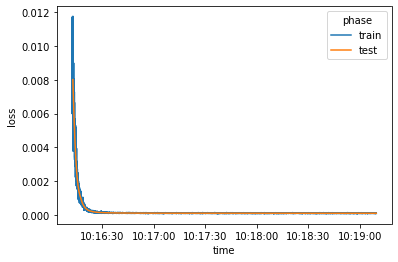

In [8]:
losses = G.conduct_optimisation(input = {"A":X_A, "B": X_B, "D": X_D},
 ground_truth={"A":X_A, "B": X_B, "C": y_C, "D": X_D, "E": y_E, "F": y_F},
test_input = {"A":X_A, "B": X_B, "D": X_D},
 test_ground_truth={"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test}
 , epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()

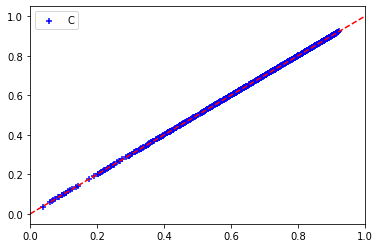

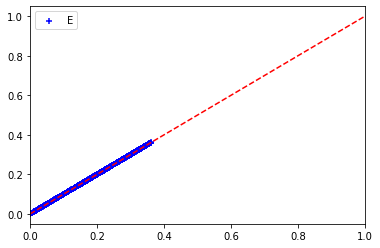

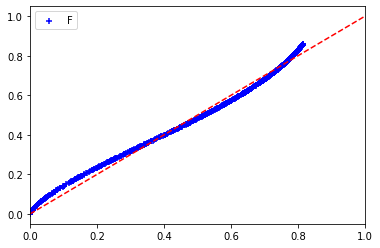

In [9]:
ident = np.linspace(0,1,100)
plt.figure()
plt.scatter(y_C_test, G.nodes()["C"]["output_state"], color="b", label="C", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_E_test, G.nodes()["E"]["output_state"], color="b", label="E", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_F_test, G.nodes()["F"]["output_state"], color="b", label="F", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()



Prediction seems similar to that of the BioMixNet on the same example, let's see if the spurious edges were turned off or not.
As a reminder :

G.add_fuzzy_node("A_OR_E_OR_D", "OR")
G.add_transfer_edge("D", "A_OR_E_OR_D")
G.add_simple_edge("A_OR_E", "A_OR_E_OR_D")

are the spurious nodes and edges. D should not influence F. So we should have that the transfer edge between "D" and "A_OR_E_OR_D" should be turned OFF.


For edge ('A', 'A_OR_B'), n has value 1.9999483712083563 and K has value 0.4999867053672607, giving a Hill function resembling that:


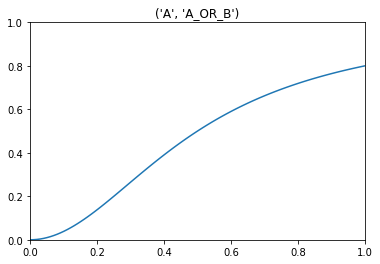

For edge ('A', 'A_OR_E'), n has value 1.516183747305147 and K has value 0.3015778594181835, giving a Hill function resembling that:


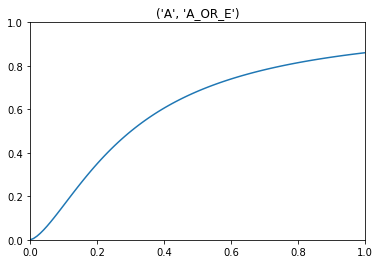

For edge ('B', 'A_OR_B'), n has value 1.000024268032338 and K has value 0.6000122789351512, giving a Hill function resembling that:


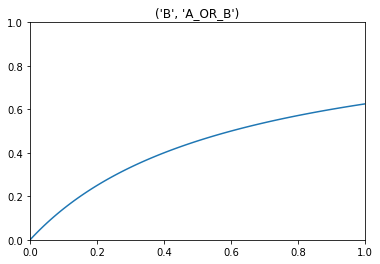

For edge ('C', 'C_AND_D'), n has value 1.3995320428942222 and K has value 0.7003403777897108, giving a Hill function resembling that:


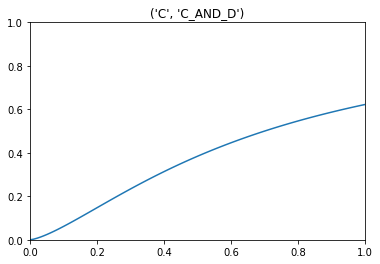

For edge ('D', 'C_AND_D'), n has value 1.0002943576285255 and K has value 0.599616713876242, giving a Hill function resembling that:


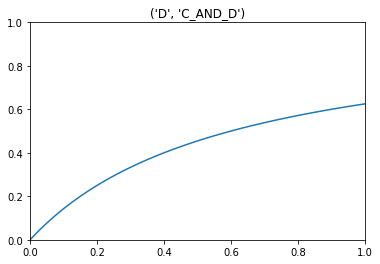

For edge ('D', 'A_OR_E_OR_D'), n has value 6.724402913841057 and K has value 3.160204027491191, giving a Hill function resembling that:


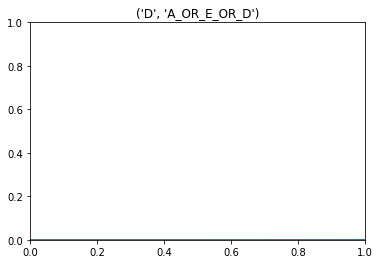

For edge ('E', 'A_OR_E'), n has value 5.49964712703867 and K has value 1.286432384435506, giving a Hill function resembling that:


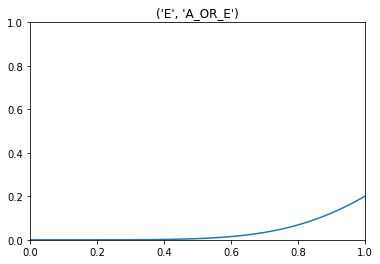

In [10]:
# Plot all the Hill functions
x = np.linspace(0,1,100)
for edge in G.transfer_edges:
    n = torch.exp(G.edges()[edge]["layer"].n).detach().item()
    K = torch.exp(G.edges()[edge]["layer"].K).detach().item()
    print(f"For edge {edge}, n has value {n} and K has value {K}, giving a Hill function resembling that:")
    plt.plot(x, [Hill(x[i],1, n, K) for i in range(len(x))])
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.title(edge)
    plt.show()

**It does indeed seem like the spurious edge has been turned OFF, with a maximum at 4e-4 which is 500 times smaller than 0.2 the second smallest activation!!**

In [11]:
plt.close("all")

In [12]:
# Compute the Root Mean Squared Error on the test set

print(utils.compute_RMSE_outputs(G, {"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test}))



{'A': 0.0, 'B': 0.0, 'C': 4.070637603079439e-06, 'D': 0.0, 'E': 8.976295898977336e-06, 'F': 0.024368163421004903}


In [13]:
print(max(utils.compute_RMSE_outputs(G, {"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test})))




F


# Same thing but this time the spurious gate is AND

If the spurious gate is AND, then the edge should be set as close to 1 as possible since 1 AND x = x

In [14]:
G = biofuzznet.BioFuzzNet()

G.add_fuzzy_node("A", "BIO")
G.add_fuzzy_node("B", "BIO")
G.add_fuzzy_node("C", "BIO")
G.add_fuzzy_node("D", "BIO")
G.add_fuzzy_node("E", "BIO")
G.add_fuzzy_node("F", "BIO")

G.add_fuzzy_node("A_OR_B", "OR")
G.add_fuzzy_node("C_AND_D", "AND")
G.add_fuzzy_node("A_OR_E", "OR")

G.add_transfer_edge("A", "A_OR_B")
G.add_transfer_edge("B", "A_OR_B")
G.add_simple_edge("A_OR_B", "C")
G.add_transfer_edge("C", "C_AND_D")
G.add_transfer_edge("D", "C_AND_D")
G.add_simple_edge("C_AND_D", "E")
G.add_transfer_edge("A", "A_OR_E")
G.add_transfer_edge("E", "A_OR_E")
#G.add_simple_edge("A_OR_E", "F") # True edge

G.add_fuzzy_node("A_OR_E_AND_D", "AND")
G.add_transfer_edge("D", "A_OR_E_AND_D")
G.add_simple_edge("A_OR_E", "A_OR_E_AND_D")
G.add_simple_edge("A_OR_E_AND_D", "F")

In [15]:
epochs = 300
batch_size = 50
learning_rate = 5e-3

In [16]:
for node, attributes in G.nodes(data=True):
    print(node)
    print(attributes["node_type"])

A
biological
B
biological
C
biological
D
biological
E
biological
F
biological
A_OR_B
logic_gate_OR
C_AND_D
logic_gate_AND
A_OR_E
logic_gate_OR
A_OR_E_AND_D
logic_gate_AND


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [02:55<00:00,  1.71it/s]


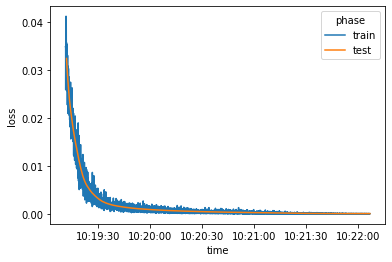

In [17]:
losses = G.conduct_optimisation(input = {"A":X_A, "B": X_B, "D": X_D},
 ground_truth={"A":X_A, "B": X_B, "C": y_C, "D": X_D, "E": y_E, "F": y_F},
test_input = {"A":X_A, "B": X_B, "D": X_D},
 test_ground_truth={"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test}
 , epochs=epochs, learning_rate=learning_rate, batch_size=batch_size  )
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()

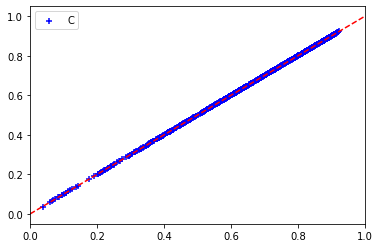

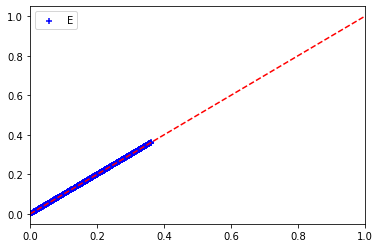

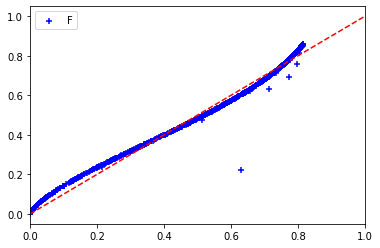

In [18]:
ident = np.linspace(0,1,100)
plt.figure()
plt.scatter(y_C_test, G.nodes()["C"]["output_state"], color="b", label="C", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_E_test, G.nodes()["E"]["output_state"], color="b", label="E", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()

plt.figure()
plt.scatter(y_F_test, G.nodes()["F"]["output_state"], color="b", label="F", marker="+")
plt.plot(ident, ident, "r--")
plt.xlim(0,1)
plt.legend()
plt.show()



Prediction seems similar to that of the BioMixNet on the same example, let's see if the spurious edges were turned on or not.
As a reminder :

G.add_fuzzy_node("A_OR_E_AND_D", "AND")
G.add_transfer_edge("D", "A_OR_E_AND_D")
G.add_simple_edge("A_OR_E", "A_OR_E_AND_D")

are the spurious nodes and edges. D should not influence F. So we should have that the transfer edge between "D" and "A_OR_E_AND_D" should be turned ON since the neutral element for the AND operation is 1.


For edge ('A', 'A_OR_B'), n has value 1.999861148271617 and K has value 0.4999975162907664, giving a Hill function resembling that:


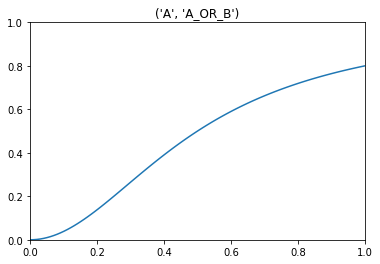

For edge ('A', 'A_OR_E'), n has value 1.5137164612021488 and K has value 0.3015344334338922, giving a Hill function resembling that:


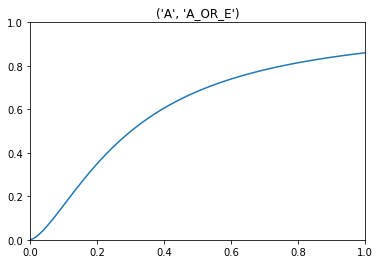

For edge ('B', 'A_OR_B'), n has value 1.000029039347499 and K has value 0.6000279497090367, giving a Hill function resembling that:


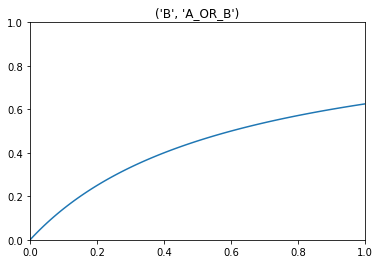

For edge ('C', 'C_AND_D'), n has value 1.4013642056481628 and K has value 0.6986065787095568, giving a Hill function resembling that:


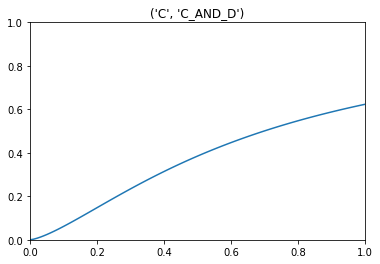

For edge ('D', 'C_AND_D'), n has value 0.9989739040903514 and K has value 0.6016865243196876, giving a Hill function resembling that:


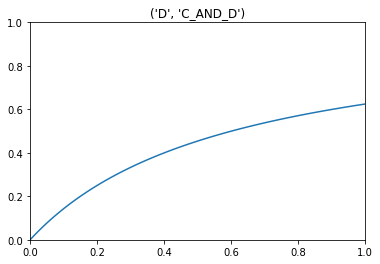

For edge ('D', 'A_OR_E_AND_D'), n has value 2.4852921667037404 and K has value 0.0017749718309690548, giving a Hill function resembling that:


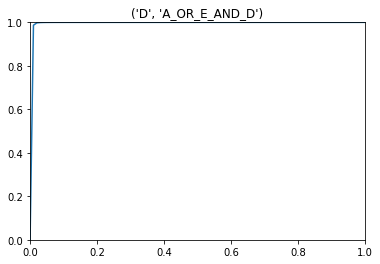

For edge ('E', 'A_OR_E'), n has value 3.824690534735806 and K has value 1.991933283414893, giving a Hill function resembling that:


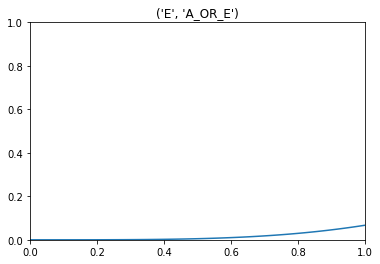

In [19]:
# Plot all the Hill functions
x = np.linspace(0,1,100)
for edge in G.transfer_edges:
    n = torch.exp(G.edges()[edge]["layer"].n).detach().item()
    K = torch.exp(G.edges()[edge]["layer"].K).detach().item()
    print(f"For edge {edge}, n has value {n} and K has value {K}, giving a Hill function resembling that:")
    plt.plot(x, [Hill(x[i],1, n, K) for i in range(len(x))])
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.title(edge)
    plt.show()

**It does indeed seem like the spurious edge has been turned ON, with a maximum at 4e-4 which is 500 times smaller than 0.2 the second smallest activation!!**

In [20]:
plt.close("all")

In [21]:
# Compute the Root Mean Squared Error on the test set

print(utils.compute_RMSE_outputs(G, {"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test}))



{'A': 0.0, 'B': 0.0, 'C': 7.605722756383194e-06, 'D': 0.0, 'E': 2.2316117319985217e-05, 'F': 0.027837161141354816}


In [22]:
print(max(utils.compute_RMSE_outputs(G, {"A":X_A_test, "B": X_B_test, "C": y_C_test, "D": X_D_test, "E": y_E_test, "F": y_F_test})))




F


# Real life network

Let's try it on the manual network with a BioFuzzNet simulation. I'll add a couple spurious edges and we'll see what happens.

GADS and mTOR have only one input normally. I added a spurious edge JAK3 -> GADS and Lck -| mTOR. This should create 2 OR gates as parents of GADS and mTOR, and the transfer edges JAK3 -> OR and Lck -> NOY should be turned OFF.

JAK3 -> OR should be set to 0 since that's the neutral for OR
and Lck -> NOT should be set to 1 so that NOT Lck is 0 which is the neutral for OR

In [24]:
# Load the results from the 2 optimisation rounds

model_1 = pickle.load(open("identifiability_scripts/report_identifiability_OR_1/model.p", "rb"))
model_2 = pickle.load(open("identifiability_scripts/report_identifiability_OR_2/model.p", "rb"))

ground_truth_data_1 = pickle.load(open("identifiability_scripts/dataset_MNfull_3600cells_seed_2/test_ground_truth.p", "rb"))
ground_truth_data_2 = pickle.load(open("identifiability_scripts/dataset_MNfull_3600cells_seed_2000/test_ground_truth.p", "rb"))

In [30]:
def analyse_identifiability_results(model,  ground_truth: dict, spurious_edges):
    """
    
        Args:
            - spurious edges: list of the names of the spurious edges (you might have to go looking for them before")
    """
    model.set_network_ground_truth(ground_truth)
    model.sequential_update(model.root_nodes)
    output_states = model.output_states
    
    print("Predictions vs Ground truth")
    # print the output
    for node in model.biological_nodes:
        if node not in model.root_nodes:
            plt.scatter(ground_truth[node].detach().numpy(), output_states[node].detach().numpy(), s=3)
    ident = np.linspace(0,1,100)
    plt.plot(ident, ident, "--k", alpha = 0.02)
    plt.show()
    
    print("RMSE on the predictions")
    RMSE = utils.compute_RMSE_outputs(model, ground_truth)
    print(RMSE)
    print(f"MAX RMSE is {max(RMSE.values())}.")
    
    print("Look at the spurious transfer edge")
    x = np.linspace(0,1,100)
    for edge in spurious_edges:
        n = torch.exp(model.edges()[edge]["layer"].n).detach().item()
        K = torch.exp(model.edges()[edge]["layer"].K).detach().item()
        print(f"For edge {edge}, n has value {n} and K has value {K}, giving a Hill function resembling that:")
        plt.plot(x, [Hill(x[i],1, n, K) for i in range(len(x))], "r")
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.title(edge)
        plt.show()

## Find out which are the spurious transfer edges

In [31]:
# For JAK3 it should be an edge leading to an OR gate which is a parent node to GADS
print(list(model_1.successors("JAK3")))
print(list(model_1.successors("or8")))
# It is the edge (JAK3, or8)

['STAT5', 'or8']
['GADS']


In [32]:
# For Lck it should be an edge leading to an NOT gate which is a parent node to an OR gate
# which is a parent onde to mTOR
print(list(model_1.successors("Lck")))
print("Investigating not2")
print(list(model_1.successors("not2")))
print(list(model_1.successors("or18")))
print("Investigating not18")
print(list(model_1.successors("not18")))
print(list(model_1.successors("or27")))
# It is the edge (Lck, not18)

['not2', 'not18', 'or19']
Investigating not2
['or18']
['GSK3b']
Investigating not18
['or27']
['mTOR']


Predictions vs Ground truth


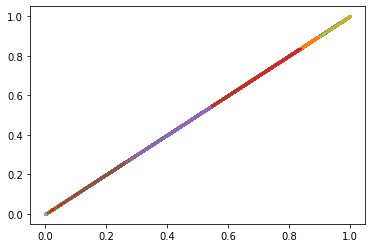

RMSE on the predictions
{'CD28': 0.0, 'PI3K': 4.6867008898223044e-05, 'Lck': 3.239179326642889e-06, 'Grb2': 9.558301629671414e-05, 'GADS': 9.79192622992037e-06, 'Akt': 0.00041514088832025745, 'AP1': 1.8592935823222206e-05, 'ERK12': 4.014875787580736e-05, 'GSK3b': 9.044889094128745e-05, 'CD3z': 5.279373200712794e-05, 'PLCg1': 4.8154273929780884e-05, 'MAPK': 3.7092728111624985e-05, 'mTOR': 0.0002676788442247809, 'Bad': 0.00013094733872488393, 'cNFkB': 0.00022322300154473348, 'NFAT': 3.184577594747762e-05, 'p38': 8.551949945193319e-05, 'Bcl2': 3.433123821529705e-05, 'BclXL': 7.045778966077902e-05, 'NFkB': 2.741897910345808e-05, 'IL2': 1.2424175182751125e-05, '41BB': 0.0, 'TRAF1': 1.0031967268896479e-05, 'TRAF2': 9.571315644131567e-06, 'TRAF3': 6.312136707606602e-07, 'ncNFkB': 5.501459829689106e-06, 'CD40': 0.0, 'TRAF6': 3.1283167925913956e-05, 'JAK3': 9.212195976731753e-09, 'STAT5': 3.8485822998543735e-09, 'TNFa': 1.1160959618177504e-09, 'IL6': 4.005832494811159e-09, 'IFNG': 4.52067718088

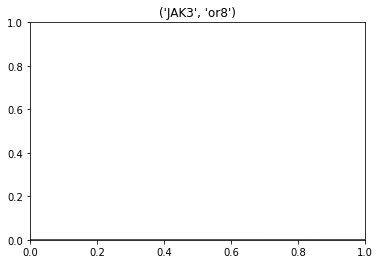

For edge ('Lck', 'not18'), n has value 7.627587948505062 and K has value 0.0003405795527766572, giving a Hill function resembling that:


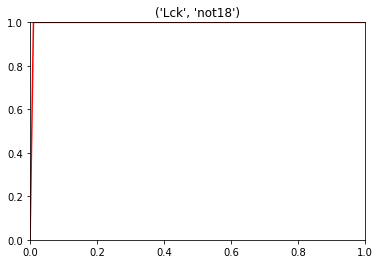

In [33]:
analyse_identifiability_results(model_1, ground_truth_data_1, [("JAK3", "or8"), ("Lck", "not18")])

Predictions vs Ground truth


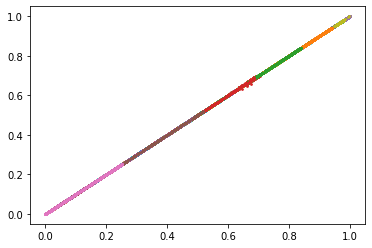

RMSE on the predictions
{'CD28': 0.0, 'PI3K': 0.0001092011844988634, 'Lck': 6.275558212966402e-05, 'Grb2': 2.4007090152996555e-05, 'GADS': 1.0865127809300463e-05, 'Akt': 8.649540330458507e-05, 'AP1': 2.5153900453567126e-05, 'ERK12': 4.908370263392792e-05, 'GSK3b': 0.00037510209475471513, 'CD3z': 9.678777252160346e-05, 'PLCg1': 0.00045717977923896393, 'MAPK': 0.00030428691605328956, 'mTOR': 2.6789473121739395e-05, 'Bad': 5.613144985053932e-05, 'cNFkB': 0.002996854395644097, 'NFAT': 5.469710872893674e-05, 'p38': 5.8588249482566064e-05, 'Bcl2': 3.6129159861597436e-05, 'BclXL': 0.00010993568072358191, 'NFkB': 0.0007659243168807469, 'IL2': 0.0006020140251564535, '41BB': 0.0, 'TRAF1': 7.37096483558556e-05, 'TRAF2': 0.00010845723640456847, 'TRAF3': 1.9216538758187897e-05, 'ncNFkB': 0.00023253356515666416, 'CD40': 0.0, 'TRAF6': 0.0001321069148393817, 'JAK3': 4.1108115071879247e-07, 'STAT5': 1.0484350065112908e-07, 'TNFa': 4.491244940742459e-07, 'IL6': 3.5206076102590814e-07, 'IFNG': 2.49570824

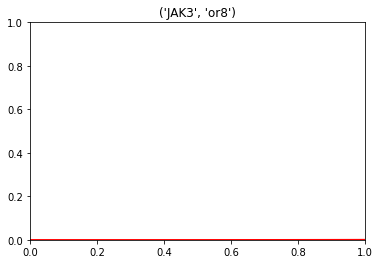

For edge ('Lck', 'not18'), n has value 6.917237853974824 and K has value 0.0020356980807946703, giving a Hill function resembling that:


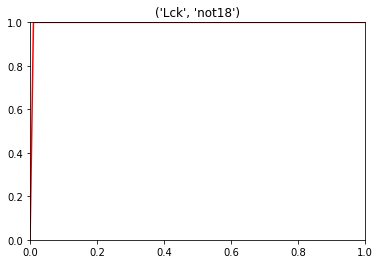

In [34]:
analyse_identifiability_results(model_2, ground_truth_data_2, [("JAK3", "or8"), ("Lck", "not18")])

JAK3 -> OR -> GADS is correctly set to OFF
Lck -> NOT (from Lck -> NOT -> OR -> mTOR) is correctly set to ON. Indeed, this leads to NOT Lck being set to OFF which is the neutral element for the logical OR operation. (NB: on a previous try with different simulated data I didn't have such good results, which ight have been linked to the range of values spawned by the data? (hard to know I don't remember which data I used...)

## The same thing but this time we have spurious AND gates

This time I hardcoded the spurous edges so I know exactly what to look for.

* Lck -1  Akt_and_NOTLck: I need to find the not gate which is parent to Akt_AND_NOTLck. Then the spurious edge is (Lck, notgate). This edge is spurious and should be turned to 0, so that not Lck has value 1 which is the neutral element for the logical AND operation.

* JAK3    1   CD28_and_JAK3: This edge should be set to 1 which is the neutral element for te logical AND operation.


In [35]:
# Load the results from the 2 optimisation rounds

model_1 = pickle.load(open("identifiability_scripts/report_identifiability_AND_seed_2//model.p", "rb"))
model_2 = pickle.load(open("identifiability_scripts/report_identifiability_AND_seed_2000//model.p", "rb"))

ground_truth_data_1 = pickle.load(open("identifiability_scripts/dataset_MNfull_3600cells_seed_2/test_ground_truth.p", "rb"))
ground_truth_data_2 = pickle.load(open("identifiability_scripts/dataset_MNfull_3600cells_seed_2000/test_ground_truth.p", "rb"))

In [36]:
# Find the correct NOT node between Lck and Akt_and_NOTLck

print(list(model_1.predecessors("Akt_and_NOTLck")))
# It is "not18"

['Akt', 'not18']


Predictions vs Ground truth


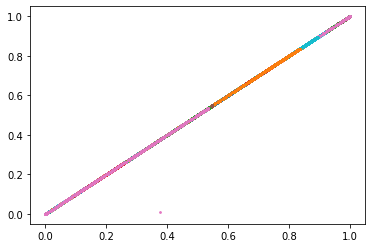

RMSE on the predictions
{'CD28': 0.0, 'PI3K': 3.0206777278317626e-05, 'Lck': 2.683763288607588e-05, 'Grb2': 2.4969123420241903e-05, 'GADS': 0.01498191730354116, 'Akt': 0.00047512375820064, 'AP1': 2.349639684414818e-05, 'ERK12': 4.4454063827435096e-05, 'GSK3b': 0.00017015896538740674, 'CD3z': 4.607781076527393e-05, 'PLCg1': 3.22584711854379e-05, 'MAPK': 0.0002577490129904946, 'mTOR': 0.00012343986842868002, 'Bad': 0.0003332199469727426, 'cNFkB': 0.0004476619115976725, 'NFAT': 2.2680932951419098e-05, 'p38': 0.00011084870146710473, 'Bcl2': 0.0001562335248603102, 'BclXL': 8.517887766135366e-05, 'NFkB': 0.0005798816731122015, 'IL2': 0.00017056695526250794, '41BB': 0.0, 'TRAF1': 2.8147706500887337e-05, 'TRAF2': 6.10473551538338e-05, 'TRAF3': 3.9242245793719086e-05, 'ncNFkB': 0.00026315949289561186, 'CD40': 0.0, 'TRAF6': 3.7496068165899305e-05, 'JAK3': 1.7163701356324746e-07, 'STAT5': 4.335662041884239e-08, 'TNFa': 2.004714812912739e-08, 'IL6': 7.503515570628239e-08, 'IFNG': 5.346826548654682

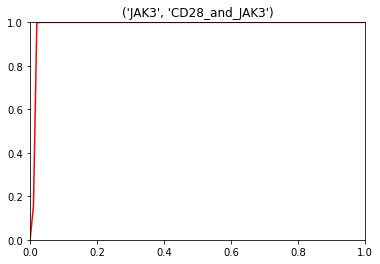

For edge ('Lck', 'not18'), n has value 3.789920589454601 and K has value 10.525114067379679, giving a Hill function resembling that:


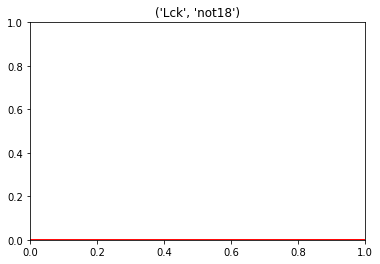

In [39]:
analyse_identifiability_results(model_1, ground_truth_data_1, [("JAK3", "CD28_and_JAK3"), ("Lck", "not18")])

Predictions vs Ground truth


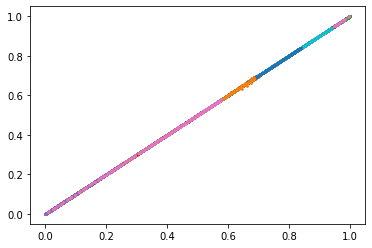

RMSE on the predictions
{'CD28': 0.0, 'PI3K': 9.849061466293728e-05, 'Lck': 6.879211925479158e-05, 'Grb2': 1.99048060637446e-05, 'GADS': 1.921150032861114e-06, 'Akt': 8.83439629980046e-05, 'AP1': 7.840978985233702e-05, 'ERK12': 0.00012883210605593045, 'GSK3b': 0.0002792676654066943, 'CD3z': 8.469314304955018e-05, 'PLCg1': 4.534530637703935e-05, 'MAPK': 0.00026940809744866996, 'mTOR': 3.972119341671373e-05, 'Bad': 0.00014579928462326864, 'cNFkB': 0.0030898644660203524, 'NFAT': 3.9103662206836934e-05, 'p38': 5.459749921824021e-05, 'Bcl2': 0.00014148658546259685, 'BclXL': 0.00010659852229088204, 'NFkB': 0.0007512089958524255, 'IL2': 0.0005548456688122593, '41BB': 0.0, 'TRAF1': 0.0001630563959170998, 'TRAF2': 0.0001309600470493251, 'TRAF3': 8.254882010472584e-06, 'ncNFkB': 0.00026755078187106304, 'CD40': 0.0, 'TRAF6': 0.0001295226663960643, 'JAK3': 3.3973434706529248e-06, 'STAT5': 2.44260476708803e-06, 'TNFa': 1.0040446290907848e-06, 'IL6': 2.113615099187305e-06, 'IFNG': 3.707819663186734e

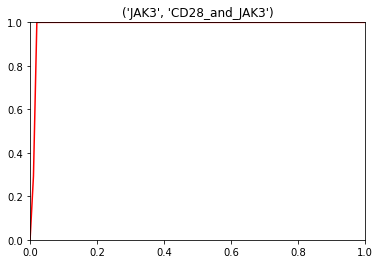

For edge ('Lck', 'not18'), n has value 3.6999093352871117 and K has value 9.335886577498531, giving a Hill function resembling that:


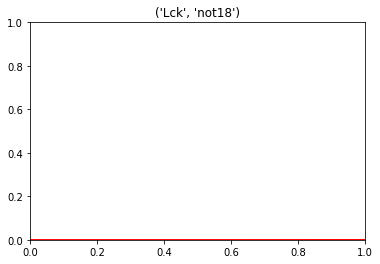

In [40]:
analyse_identifiability_results(model_2, ground_truth_data_2, [("JAK3", "CD28_and_JAK3"), ("Lck", "not18")])

# Summary identifiability

While identifiability works in a satisfactory manner for simple cases, and OR gates in more complex cases, it seems to have a harder time to identify spurious edges in the AND cases (while having a loss still 10 times higher than in the OR case, suggesting that it might be lost in a local optimum. I'm trying again with a larger learning rate).